In [1]:
import torch as t
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams["figure.figsize"]=[9,6]

In [2]:
X = np.loadtxt('features1.txt')
# Y = np.loadtxt('one_hot_labels.txt')
X_test = np.loadtxt('test_features.txt')
Y = np.loadtxt('labels1.txt')
X.dtype, Y.dtype

(dtype('float64'), dtype('float64'))

In [3]:
Y.shape

(20000,)

In [4]:
X_ = X.copy()

In [5]:
X = normalize(X, axis=0, norm='max')

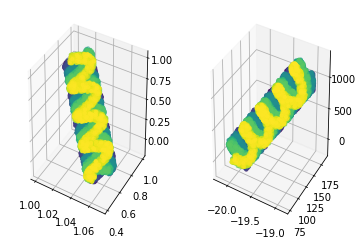

In [6]:
cm = plt.get_cmap('viridis')
col = [cm(float(i)/(len(X))) for i in range(len(X))]
fig = plt.figure()
ax3D = fig.add_subplot(121, projection='3d')
ax3D.scatter(X.T[0], X.T[1], X.T[2], s=10, c=col, marker='o')  
ax3D = fig.add_subplot(122, projection='3d')
ax3D.scatter(X_.T[0], X_.T[1], X_.T[2], s=10, c=col, marker='o')  
plt.show()

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=7)

In [8]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((15000, 3), (5000, 3), (15000,), (5000,))

In [9]:
t_X_train = t.from_numpy(X_train.astype('float32')).view(-1,3)
t_Y_train = t.from_numpy(Y_train.astype('long'))

t_X_val = t.from_numpy(X_val.astype('float32')).view(-1,3)
t_Y_val = t.from_numpy(Y_val.astype('long'))

t_X_test = t.from_numpy(X_test.astype('float32')).view(-1,3)

In [10]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((15000, 3), (5000, 3), (15000,), (5000,))

In [11]:
t_X_train.shape, t_X_val.shape, t_X_test.shape, t_Y_train.shape, t_Y_val.shape

(torch.Size([15000, 3]),
 torch.Size([5000, 3]),
 torch.Size([8000, 3]),
 torch.Size([15000]),
 torch.Size([5000]))

In [12]:
batch_size = 256

In [13]:
train_set = t.utils.data.TensorDataset(t_X_train, t_Y_train)
val_set = t.utils.data.TensorDataset(t_X_val, t_Y_val)

train_data_loader = t.utils.data.DataLoader(train_set, batch_size=batch_size)
val_data_loader = t.utils.data.DataLoader(val_set, batch_size=batch_size)

In [14]:
loss_fun = t.nn.CrossEntropyLoss()
# loss_fun = t.nn.LogSoftmax()
# loss_fun = t.nn.BCEWithLogitsLoss()

In [104]:
epochs = 25
lr = 1e-3

In [105]:
def create_model(neurons):
    entries, exits = 3, 4
    model = t.nn.Sequential(
        t.nn.Linear(entries, neurons), t.nn.ReLU(),
        t.nn.Linear(neurons, neurons*2), t.nn.ReLU(),
        t.nn.Linear(neurons*2, neurons*2), t.nn.ReLU(),
        t.nn.Linear(neurons*2, neurons*2), t.nn.ReLU(),
        t.nn.Linear(neurons*2, neurons), t.nn.ReLU(),
        t.nn.Linear(neurons, neurons), t.nn.ReLU(),
        t.nn.Linear(neurons, neurons), t.nn.ReLU(),
        t.nn.Linear(neurons, exits)
    )
                        
    return model

In [106]:
model = create_model(neurons=256)

In [107]:
optimizer = t.optim.Adam(model.parameters(), lr=lr, weight_decay=lr*0.02)

In [108]:
for p in model.parameters():
    t.nn.init.uniform_(p, -0.2, 0.2)

In [109]:
def accuracy(model, inp, target):
    pred = t.softmax(model(inp),dim=1)
    pred_class = t.argmax(pred,dim=1)
    return t.sum(pred_class == target).item()/len(target) 

In [110]:
accuracy(model, val_set[:][0], val_set[:][1])

0.2492

In [111]:
def getTrainExamples(batch, batch_size=batch_size):
    return t_X_train[batch*batch_size:(batch+1) * batch_size], \
            t_Y_train[batch*batch_size:(batch+1) * batch_size]
        

In [112]:
def cross_entropy(p, l):
    return -t.mean(l*t.log(p+1e-12))

In [113]:
def cross_entropy_loss(outputs, labels):
    outputs = t.nn.functional.log_softmax(outputs, dim=1)
    outputs = outputs[range(batch_size), labels]
    return -t.sum(outputs)/batch_size

In [114]:
%%time
err_train=[]
err_valid=[]
acc_train=[]
acc_valid=[]
for epoch in range(epochs):
    for data_ in train_data_loader:
        optimizer.zero_grad()
        outputs, target = data_
        pred = model(outputs)
        loss = loss_fun(pred, target)
        loss.backward()
        optimizer.step()
    
    with t.no_grad():
        vpred  = model(val_set[:][0])
        vloss  = loss_fun(vpred,val_set[:][1])
        err_valid.append(vloss)
        pred  = model(train_set[:][0])
        loss  = loss_fun(pred,train_set[:][1])
        err_train.append(loss)
        acc = accuracy(model, train_set[:][0], train_set[:][1])
        acc_train.append(acc)
        vacc = accuracy(model, val_set[:][0], val_set[:][1])
        acc_valid.append(vacc)

        print("epoch %d %f %f %f %f" % (epoch+1, loss, vloss, acc, vacc)) 

epoch 1 1.414839 1.403329 0.270067 0.281200
epoch 2 1.381288 1.376236 0.276000 0.287600
epoch 3 1.350906 1.351490 0.299400 0.310600
epoch 4 1.326726 1.330707 0.299400 0.311200
epoch 5 1.293399 1.302276 0.337400 0.346400
epoch 6 1.267673 1.273156 0.355600 0.367200
epoch 7 1.243262 1.244303 0.368800 0.383200
epoch 8 1.231957 1.233842 0.384867 0.398200
epoch 9 1.194899 1.195068 0.395133 0.408800
epoch 10 1.148432 1.157328 0.408133 0.402600
epoch 11 1.098330 1.097724 0.464733 0.465800
epoch 12 1.086758 1.092349 0.471000 0.459600
epoch 13 1.086975 1.096264 0.466867 0.458600
epoch 14 1.008454 1.025027 0.525400 0.510000
epoch 15 0.948918 0.962890 0.547933 0.538000
epoch 16 0.955804 0.958799 0.548200 0.542400
epoch 17 0.958910 0.958316 0.550400 0.545000
epoch 18 0.939974 0.937798 0.557133 0.555200
epoch 19 0.911895 0.910564 0.567333 0.566400
epoch 20 0.892029 0.891892 0.573667 0.571800
epoch 21 0.874039 0.878600 0.583733 0.578800
epoch 22 0.868138 0.874927 0.587333 0.581200
epoch 23 0.844938 0

In [115]:
print('Train:\t', accuracy(model, train_set[:][0], train_set[:][1]))
print('Test:\t', accuracy(model, val_set[:][0], val_set[:][1]))

Train:	 0.5919333333333333
Test:	 0.5754


In [120]:
lr=5e-4
optimizer = t.optim.Adam(model.parameters(), lr=lr, weight_decay=lr*0.02)

In [121]:
%%time
for epoch in range(epochs):
    for data_ in train_data_loader:
        optimizer.zero_grad()
        outputs, target = data_
        pred = model(outputs)
        loss = loss_fun(pred, target)
        loss.backward()
        optimizer.step()
    
    with t.no_grad():
        vpred  = model(val_set[:][0])
        vloss  = loss_fun(vpred,val_set[:][1])
        err_valid.append(vloss)
        pred  = model(train_set[:][0])
        loss  = loss_fun(pred,train_set[:][1])
        err_train.append(loss)
        acc = accuracy(model, train_set[:][0], train_set[:][1])
        acc_train.append(acc)
        vacc = accuracy(model, val_set[:][0], val_set[:][1])
        acc_valid.append(vacc)

        print("epoch %d %f %f %f %f" % (epoch+1, loss, vloss, acc, vacc)) 

epoch 1 0.833361 0.853781 0.603200 0.592000
epoch 2 0.813026 0.834535 0.610800 0.589400
epoch 3 0.813220 0.835274 0.613800 0.585600
epoch 4 0.823610 0.845887 0.609200 0.583200
epoch 5 0.793004 0.814516 0.623333 0.598200
epoch 6 0.780187 0.802402 0.631133 0.608000
epoch 7 0.752284 0.775719 0.643333 0.630200
epoch 8 0.741347 0.764312 0.651267 0.638800
epoch 9 0.735959 0.758326 0.656667 0.646600
epoch 10 0.716941 0.740881 0.671067 0.655600
epoch 11 0.682130 0.707993 0.686000 0.672600
epoch 12 0.683057 0.705376 0.687600 0.674000
epoch 13 0.675698 0.696334 0.690133 0.681200
epoch 14 0.633290 0.654105 0.712267 0.705400
epoch 15 0.585884 0.610470 0.734933 0.725800
epoch 16 0.634028 0.650344 0.706867 0.704600
epoch 17 0.611032 0.625422 0.713533 0.715600
epoch 18 0.641922 0.650665 0.698133 0.700200
epoch 19 0.569350 0.585108 0.736867 0.734600
epoch 20 0.488613 0.511060 0.773667 0.761600
epoch 21 0.610325 0.614419 0.714400 0.715600
epoch 22 0.570869 0.573668 0.736800 0.744200
epoch 23 0.501088 0

In [122]:
print('Train:\t', accuracy(model, train_set[:][0], train_set[:][1]))
print('Test:\t', accuracy(model, val_set[:][0], val_set[:][1]))

Train:	 0.7685333333333333
Test:	 0.7744


In [153]:
model_ = model
lr=2e-4
optimizer = t.optim.Adam(model.parameters(), lr=lr)

In [154]:
%%time
for epoch in range(epochs):
    for data_ in train_data_loader:
        optimizer.zero_grad()
        outputs, target = data_
        pred = model(outputs)
        loss = loss_fun(pred, target)
        loss.backward()
        optimizer.step()
    
    with t.no_grad():
        vpred  = model(val_set[:][0])
        vloss  = loss_fun(vpred,val_set[:][1])
        err_valid.append(vloss)
        pred  = model(train_set[:][0])
        loss  = loss_fun(pred,train_set[:][1])
        err_train.append(loss)
        acc = accuracy(model, train_set[:][0], train_set[:][1])
        acc_train.append(acc)
        vacc = accuracy(model, val_set[:][0], val_set[:][1])
        acc_valid.append(vacc)

        print("epoch %d %f %f %f %f" % (epoch+1, loss, vloss, acc, vacc)) 

epoch 1 0.337446 0.348131 0.837133 0.830000
epoch 2 0.399427 0.402378 0.810467 0.814800
epoch 3 0.334234 0.344605 0.838000 0.833400
epoch 4 0.324115 0.336028 0.841200 0.835000
epoch 5 0.311598 0.327605 0.846267 0.834800
epoch 6 0.309903 0.326175 0.844533 0.835800
epoch 7 0.309593 0.325702 0.844600 0.834200
epoch 8 0.311154 0.326140 0.845267 0.834400
epoch 9 0.311380 0.325883 0.846467 0.835400
epoch 10 0.313101 0.327224 0.845267 0.835400
epoch 11 0.316010 0.329527 0.843933 0.836600
epoch 12 0.311069 0.326287 0.844600 0.833800
epoch 13 0.306643 0.323418 0.845800 0.834400
epoch 14 0.306845 0.323189 0.846733 0.835400
epoch 15 0.304703 0.321391 0.846933 0.836600
epoch 16 0.304128 0.320814 0.846200 0.835800
epoch 17 0.303626 0.320349 0.846733 0.835800
epoch 18 0.308600 0.323159 0.845667 0.837000
epoch 19 0.319086 0.331961 0.842867 0.837200
epoch 20 0.303144 0.322356 0.848533 0.832200
epoch 21 0.302848 0.321720 0.848800 0.834400
epoch 22 0.302774 0.320686 0.848267 0.836800
epoch 23 0.302020 0

In [155]:
print('Train:\t', accuracy(model, train_set[:][0], train_set[:][1]))
print('Test:\t', accuracy(model, val_set[:][0], val_set[:][1]))

Train:	 0.8482666666666666
Test:	 0.8362


In [151]:
unique, counts = np.unique(train_set[:][1], return_counts=True)
dict(zip(unique, counts))

{0: 3821, 1: 3754, 2: 3679, 3: 3746}

In [156]:
t_X_test[:].shape

torch.Size([8000, 3])

In [157]:
prediction = model(t_X_test)

In [158]:
prediction[:10]

tensor([[  3648.5029,   1142.2505,  -7041.2661,  -1561.5330],
        [ -8488.9512, -11626.3887,   5296.4678,   9530.3242],
        [ -7802.9102,  -6380.5146,   5689.9092,   5469.7129],
        [ -6318.2280, -11920.8027,   3097.2114,   9585.7803],
        [ -8454.6768,  -8985.9502,   5839.8740,   7480.4688],
        [ -7028.5469,  -2295.1238,   5637.4995,   2474.8242],
        [ -8052.9194,  -3782.2727,   6241.7544,   3640.9268],
        [ -6760.8203,  -6181.7793,   4891.1768,   5228.7808],
        [ -8462.6855, -12440.4609,   5044.6782,  10142.4736],
        [ -8453.7246,  -8361.6953,   5918.3638,   6995.7026]],
       grad_fn=<SliceBackward>)

In [159]:
_, predicted = t.max(prediction, 1)

In [160]:
np_predicted = predicted.numpy()
np_predicted[:50]

array([0, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       3, 2, 2, 2, 2, 3, 2, 2, 2, 0, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2,
       2, 2, 2, 2, 3, 3])

In [161]:
unique, counts = np.unique(np_predicted, return_counts=True)
dict(zip(unique, counts))

{0: 136, 1: 2, 2: 3472, 3: 4390}

In [147]:
np.savetxt('prediction.txt', np_predicted.astype(int))

In [145]:
print('Train:\t', accuracy(model, train_set[:][0], train_set[:][1]))
print('Test:\t', accuracy(model, val_set[:][0], val_set[:][1]))

Train:	 0.8426
Test:	 0.8336


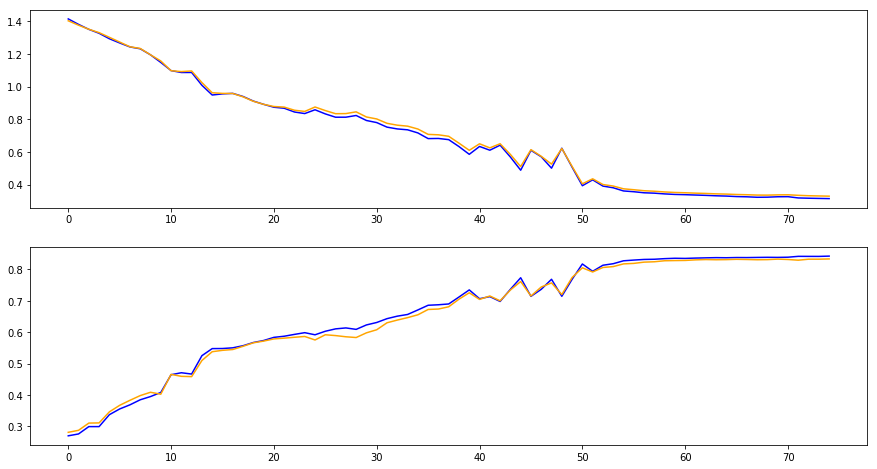

In [146]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(err_train,'blue')
plt.plot(err_valid,c='orange')
plt.subplot(212)
plt.plot(acc_train,'blue')
plt.plot(acc_valid,c='orange')
plt.show()